In [123]:
import os
#import ipdb

import pandas as pd
import matplotlib as mpl
from matplotlib import lines
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

EXP_NAME = "c10"
headers = ['time','start_transfer', 'latency','gateway','status']
def read_client():
    INPUT_DIR = os.path.join( os.getcwd(), EXP_NAME)
    data = pd.DataFrame()
    dirs = [f for f in os.listdir(INPUT_DIR) if os.path.isdir(os.path.join(INPUT_DIR))]    
    for client in dirs:
        client_data = pd.read_csv(os.path.join(INPUT_DIR, client), sep=',')
        client_data.columns= headers
        client_data = client_data.set_index(pd.DatetimeIndex(client_data.time))
        client_data = client_data.query('status == 200')
        data = pd.concat([data, client_data])
    return data
    
def getECDF(df,column):
    """Helper function that caclulates the ECDF of a dataframe"""
    df = df[column].value_counts()
    ecdf = df.sort_index().cumsum()*1./df.sum()    
    return ecdf

In [134]:
data = read_client()
std_data = pd.DataFrame()

std_data = data['latency'].sort_index().rolling('5T').std().to_frame()
mean_data = data['latency'].sort_index().rolling('1T').mean().to_frame()
general  = pd.merge(std_data, mean_data, how='inner', left_index=True, right_index=True)
general.columns = ['std','mean']
#std_data.to_csv('std_dev/general_std.csv')

for name, group in data.groupby(data['gateway']):
    group_std = pd.DataFrame()
    group_std = group['latency'].rolling('5T').std().to_frame()
    group_mean = group['latency'].rolling('1T').mean().to_frame()
    group_data = pd.merge(group_std, group_mean, how='inner', left_index=True, right_index=True)
    group_data.columns = ['std', 'mean']
    merged = pd.merge(group_data, general, how='inner', left_index=True, right_index=True)
    merged.columns = ['std', 'latency', 'all_std','mean_latency']
    merged.to_csv('std_dev/'+name+'.csv')
    print(name, group.latency.quantile(0.75))
    #group['latency'].plot()

#plt.ylim(0,1)
#plt.show()

10.138.120.66 0.055733250000000005
10.138.25.67 0.0566585
10.138.57.2 0.05533300000000001
10.138.85.130 0.5409079999999999
10.139.17.4 0.11169075000000002
10.139.37.194 0.47328
10.139.40.122 0.040257999999999995
10.139.40.85 0.062155999999999996
10.139.94.98 0.769949
10.140.93.35 0.9485190000000001
10.228.192.210 0.344778
10.228.193.210 0.460137
proxy.cecilia.guifi.net 0.06765125
proxy.elpipa.guifi.net 0.06841325000000001
proxy.malla.guifi.net 0.309249
proxy.muntanyola.guifi.net 0.06796125
proxy.olost.guifi.net 0.068374
proxy.perafita.guifi.net 0.067816
proxy.sbll.guifi.net 0.50267825
proxy.smc.guifi.net 4.990053


In [109]:
import os
#import ipdb

import pandas as pd
import matplotlib as mpl
from matplotlib import lines
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

EXP_NAME = "std_dev"
# Read all standard deviation files of each gateway node and count what category nodes are at each time period
def read_std():
    INPUT_DIR = os.path.join( os.getcwd(), EXP_NAME)
    data = pd.DataFrame()
    dirs = [f for f in os.listdir(INPUT_DIR) if os.path.isdir(os.path.join(INPUT_DIR))]    
    for client in dirs:
        client_data = pd.read_csv(os.path.join(INPUT_DIR, client), sep=',')
        client_data = client_data.set_index(pd.DatetimeIndex(client_data.time))
        #client_data = client_data.tail(1000)
        
        client_data = client_data.ix['2019-02-10 00:00':'2019-02-19 00:00']
        print(client)
        for index, row in client_data.iterrows():
            if row['mean_latency'] is None:
                continue
            if row['latency'] <= row['mean_latency']:
                if row['std'] <= row['all_std']:
                    client_data.loc[index, 'category'] = 'Good'
                else:
                    client_data.loc[index, 'category'] = 'Inconsistent'
            else:
                if row['std'] < row['all_std']:
                    client_data.loc[index, 'category'] = 'Inconsistent'
                else:
                    client_data.loc[index, 'category'] = 'Bad'
        
        data = pd.concat([data, client_data])
    return data
category_data = read_std()

/home/khulan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


10.140.93.35.csv
proxy.cecilia.guifi.net.csv
proxy.sbll.guifi.net.csv
10.139.37.194.csv
proxy.elpipa.guifi.net.csv
proxy.muntanyola.guifi.net.csv
proxy.malla.guifi.net.csv
10.139.40.122.csv
10.138.57.2.csv
proxy.olost.guifi.net.csv
10.138.120.66.csv
10.228.192.210.csv
10.228.193.210.csv
10.139.94.98.csv
proxy.smc.guifi.net.csv
10.138.25.67.csv
proxy.perafita.guifi.net.csv
10.139.40.85.csv
10.139.17.4.csv
10.138.85.130.csv


In [110]:
category_data.index = category_data.index.map(lambda x: x.replace(second=0))
category_data.index = category_data.index.map(lambda x: x.replace(microsecond=0))
category_data = category_data.ix['2019-02-10 00:00':'2019-02-15 00:00']
category_data = category_data.sort_index()
#category_data.to_csv('help.csv')
counted_df = category_data.groupby([category_data.index, category_data['category']]).count()['latency'].unstack()
#print(counted_df)
counted_df.resample('H').mean().to_csv('category_out.csv')

#counted_df.resample('H').mean().plot()
#plt.show()


/home/khulan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until


             Bad       Good  Inconsistent
count  61.000000  61.000000     61.000000
mean    1.187330  11.877936      5.218452
std     0.145365   1.025390      0.776704
min     1.000000   9.883333      3.500000
25%     1.081081  11.300000      4.679245
50%     1.179487  11.666667      5.316667
75%     1.250000  12.483333      5.700000
max     1.636364  14.350000      6.666667


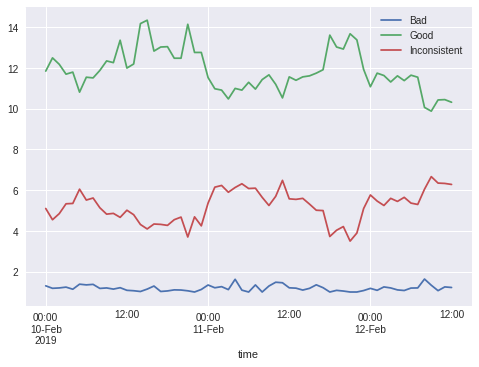

In [113]:
category_df = pd.read_csv('category_out.csv')
category_df = category_df.set_index(pd.DatetimeIndex(category_df.time))
#getECDF(category_df,'Good').plot()
#getECDF(category_df,'Inconsistent').plot()
#getECDF(category_df,'Bad').plot()

print(category_df.describe())
plt.show()

category_df.plot()
plt.show()